In [9]:
import numpy as np
import utils2 as utils
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import os


# Define measurement data, camera, and beam energy
# data_path = '../Scans/2024-08-09/Quadscan.csv'
data_path = '../Scans/2024-08-13/Quadscan.csv'

# Thresholds
std_threshold = 100 # remove datapoint if std>thresh
Q2_threshold = 1 # Remove datapoint if abs(Q2)<thresh


In [10]:

# Read data, apply calibration
if os.path.isdir(data_path):
    df = utils.merge_csvs(data_path)
else:
    df = pd.read_csv(data_path)

# Scale by calibration
df.xrms *= df.calibration
df.yrms *= df.calibration

# Group on quad currents for mean and std
grouped = df.groupby(['Q1', 'Q2', 'Q3'])
df = grouped.agg(
    xrms_mean=('xrms', 'mean'),
    xrms_std=('xrms', 'std'),    
    yrms_mean=('yrms', 'mean'),
    yrms_std=('yrms', 'std'),
    ).reset_index()


# Remove datasets with std above threshold
df = df[df.xrms_std<std_threshold]
df = df[df.yrms_std<std_threshold]

# Remove datasets far from focus
df = df[df.Q2.abs()>Q2_threshold]



----- Optimization -----
---------- X ----------
Emittance: 1.41e-07
Norm. Emittance: 2.20e-05
Beta Twiss: 2.26
Alpha Twiss: -0.15
---------- Y ----------
Emittance: 9.10e-08
Norm. Emittance: 1.42e-05
Beta Twiss: 1.94
Alpha Twiss: 0.45
Beam Matrix:
array([[ 3.17739889e-07,  2.07886505e-08,  0.00000000e+00,
         0.00000000e+00],
       [ 2.07886505e-08,  6.36261433e-08,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.76773481e-07,
        -4.06615910e-08],
       [ 0.00000000e+00,  0.00000000e+00, -4.06615910e-08,
         5.62010049e-08]])


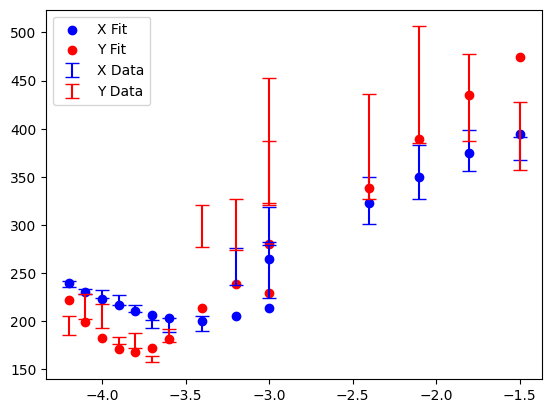

In [11]:
# Define beamline
energy = 80e6 #eV
rigidity = energy/299792458
beamline = utils.Beamline(rigidity)

# Setup optimization
quadscan = utils.QuadscanFit(beamline, df)
bounds = [(0.1, 10), (-5, 5), (.01, 5), (0.1, 10), (-5, 5), (.01, 5)] 
x0 = [1, 0, .5, 1, 0, .5]

# Run x optimization
print('----- Optimization -----')
quadscan.run(x0=x0, bounds=bounds)
fig, ax = quadscan.plot_fit()

